# Introduction

## Problem Statement

I often find myself endlessly scrolling through my photo library, searching for a particular shot—especially after a vacation or family trip when I’ve taken hundreds of pictures. While the iPhone’s built-in search lets you find “Barcelona” or “credit card,” it can’t handle longer, more detailed queries like “the mountain-top photos I took on my 2021 holiday in Switzerland.” 

To solve this, I set out to build an AI-powered image finder that accepts free-form descriptions and returns the matching photos instantly. Because processing thousands or even millions of images sequentially would be prohibitively slow—asking “Is this a mountain?” or “Does this look like Switzerland?” for each photo—I knew that parallelism would be key to making my tool responsive.


## Difficulty

### Data Collection: 
Pulling photos and metadata directly from my iPhone proved cumbersome. Instead, I turned to the publicly available Unsplash dataset, which offers free-to-use images along with rich metadata.

### Vision Model Generation: 
Implementing or calling a computer-vision model in Go proved far more involved than in Python, where libraries like PyTorch or TensorFlow are readily available. To keep the focus on parallel architecture rather than on heavy ML engineering, I leveraged Unsplash’s pre-generated “AI descriptions” for each photo. Matching the user’s natural-language prompt against these descriptions provides sufficient accuracy for now—and leaves room to explore full vision-model integration later (see Section 10).


## Solution

### Metadata Matching 
- Query parsing: Use an LLM to extract structured criteria (location, date, camera make, keywords) from free-form user text.

- Local filtering: Quickly eliminate images that don’t match metadata fields (country, city, year, etc.).

- Textual ranking: Score the remaining candidates by token overlap (with stemming and synonyms) between the user prompt and each photo’s AI-generated description.

### Parallel Implementation
- Sequential baseline: A single-threaded filter + scorer pipeline.

- BSP (bulk-synchronous) - v1: Divide the image set into T chunks, have each thread score its chunk, then merge top-K results.

- Pipeline - v2: Stream photos through filtering and scoring stages via buffered channels.

- Work-stealing - v3: Build a lock-free deque so idle threads can “steal” scoring tasks from busy ones, improving load balance.



In [6]:
# FULL EXAMPLE FOR A SPECIFIC UNSLASH IMAGE'S METADATA: 
# {
#   "photo_id": "Y-nyDv3TWm0",
#   "photo_url": "https://unsplash.com/photos/Y-nyDv3TWm0",
#   "photo_image_url": "https://images.unsplash.com/photo-1551986782-d0169b3f8fa7",
#   "photo_submitted_at": "2019-03-07 19:27:23.038234",
#   "photo_featured": "t",
#   "photo_width": 2495,
#   "photo_height": 3737,
#   "photo_aspect_ratio": 0.67,
#   "photo_description": null,
#   "photographer_username": "mudmanuk",
#   "photographer_first_name": "Paul",
#   "photographer_last_name": "Carroll",
#   "exif_camera_make": "NIKON CORPORATION",
#   "exif_camera_model": "NIKON D800",
#   "exif_iso": 200.0,
#   "exif_aperture_value": "8",
#   "exif_focal_length": "200",
#   "exif_exposure_time": "1/400",
#   "photo_location_name": null,
#   "photo_location_latitude": null,
#   "photo_location_longitude": null,
#   "photo_location_country": "South Georgia and the South Sandwich Islands",
#   "photo_location_city": "Gold Harbour",
#   "stats_views": 4848481,
#   "stats_downloads": 62649,
#   "ai_description": "two penguins on seashore during daytime",
#   "ai_primary_landmark_name": null,
#   "ai_primary_landmark_latitude": null,
#   "ai_primary_landmark_longitude": null,
#   "ai_primary_landmark_confidence": null,
#   "blur_hash": "LeDKieofT1WX%%ayR*WC?bbHxCt6"
# }

# Usage

## Prerequisite 

### Data: 

- **Images**: Given that the images take up a significant amount of memory (e.g., 2.8GB for 1000 images), I decided not to upload them to GitHub directly. Instead, I wrote a script to download a sample of them to your machine. It is available at `./proj3/scripts/get_image_sample.py`.
    - This script downloads a sample set of images and their corresponding metadata from Unsplash.
    - You can run it from the `./proj3/scripts/` directory using the command: `python get_image_sample.py N` to download N images.
    - It will download N images to `./proj3/data/<images, metadata>`.
- **Metadata**: The metadata files for the first 1000 images in the Unsplash dataset are relatively small and have been uploaded to the repository. They are located in `./proj3/data/metadata/` and are stored in JSON format.
- **Synthetic Metadata**: Given that downloading the full Unsplash dataset to test program scalability takes a huge amount of space, I decided to run the program on duplicated data for illustrative purposes. I duplicated my 1k set of metadata to simulate 25 million photo entries (the approximate full size of the Unsplash dataset, non-lite version).
    - This synthetic metadata file is also very large (approximately 2.7GB) and therefore was not included in the GitHub repository.
    - You can generate it yourself by navigating to the `proj3/` directory (one level up from `scripts/dup/`) and running a command like: `go run ./scripts/dup/dup.go -n 25000 > ./data/metadata_big.jsonl`. This example assumes you have 1,000 base metadata files and want to generate 25,000,000 entries (25,000 * 1,000 = 25,000,000). Adjust the `-n <factor>` accordingly.
    - This script stores the 25 million entries in a JSON Lines format in the file `./proj3/data/metadata_big.jsonl`.

For the data downloads on your local machine, you will find more information in ./documentation/set_up_project.txt

### Software: 
- **Go** (version 1.19 or later recommended)
- **Python** (version 3.x recommended)
- **Python packages**: `openai`, `pandas`, `matplotlib`, `seaborn`, `numpy`. These are listed in `requirements.txt` in the project root. You can install them using `pip install -r requirements.txt`.
- **OpenAi API**: The cost to run this program is relatively small (using o3-mini), so I left an API key specially created for this project in `query.go`, and the cost is around $0.001 per call / image request. This API key has a limit of a few dollars but this should be more than enough for the illustrative purposes of the project. The open AI models are only used for parsing the user query into a json format, which we then ultimately try to match to one of our image's metadata files. In future versions of this project, If i decide to use a full scale CV model to read the .png files in themselves, I expect the cost to increase by multiple orders of magnitude. 

## How to run 
More details on this can be found in the file `./documentation/run.txt`, but to summarize: 

```bash 
# Sequential Subset: 
go run ./cmd/finder

# BSP Mode on Synthetic Data (0 for full set of duplicated data, else specify a number)
go run ./cmd/finder --duplicated 0 --mode bsp --workers 10

# Pipeline Mode on Synthetic Data
go run ./cmd/finder --duplicated 0 --mode pipeline --workers 10

# Work Stealing Mode on Synthetic Data
go run ./cmd/finder --duplicated 0 --mode ws --workers 10
```

## Flags

The main application (`cmd/finder`) and the benchmark tool (`cmd/bench`) accept several command-line flags to control their behavior:

- **`duplicated`** (int):
    - Purpose: Controls the loading of duplicated (synthetic) metadata for testing scalability.
    - Usage:
        - Omit this flag (or if its internal default `-1` is used by `cmd/finder`): Loads standard metadata from the `data/metadata/` directory (1000 entries).
        - `--duplicated 0`: Loads all records from the large synthetic dataset (`data/metadata_big.jsonl`).
        - `--duplicated N` (where `N > 0`): Loads a subset of `N` records from the synthetic dataset.
    - Default (for `cmd/finder`): `-1` (uses standard small dataset).
    - Default (for `cmd/bench` if not specified): `1000000` (can be overridden).

- **`mode`** (string):
    - Purpose: Specifies the execution mode for the ranking/scoring phase.
    - Values:
        - `"seq"`: Sequential execution.
        - `"bsp"`: Bulk Synchronous Parallel execution.
        - `"pipeline"`: Pipelined parallel execution.
        - `"ws"`: Work-Stealing parallel execution.
    - Default: `"seq"`.

- **`workers`** (int):
    - Purpose: Specifies the number of worker goroutines for parallel modes that use a fixed pool of workers for the primary parallel task (i.e., `"bsp"` and `"ws"` modes).
    - Default: Number of logical CPU cores available (`runtime.NumCPU()`).

- **`scorers`** (int):
    - Purpose: Specifies the number of scorer worker goroutines specifically for the `"pipeline"` mode.
    - Default: Number of logical CPU cores available (`runtime.NumCPU()`).

- **`topk`** (int):
    - Purpose: Determines the number of top-ranked results to return after the AI-assisted textual ranking phase.
    - Default: `5`.

- **`limit`** (int):
    - Purpose: In the interactive `cmd/finder` application, this flag sets the maximum number of metadata-filtered candidate photos to preview when the user chooses the "see" option.
    - Default: `10`.

# Design & Architecture

## High-level pipeline 

We can break down the pipeline into two different viewpoints: User or Backend perspective 
### User Perspective: 
I will include two example runs below. One will be based on the metadata only (the user knows the location / date / photographer), and for the second one, the user doesn't know where and when the picture was taken but he describes what he is looking like to the AI. 

#### First scenario: user knows location / date or photographer. 
In this case, the user is interested in finding the image of a Fjord he took during his trip to Norway in 2018.

        



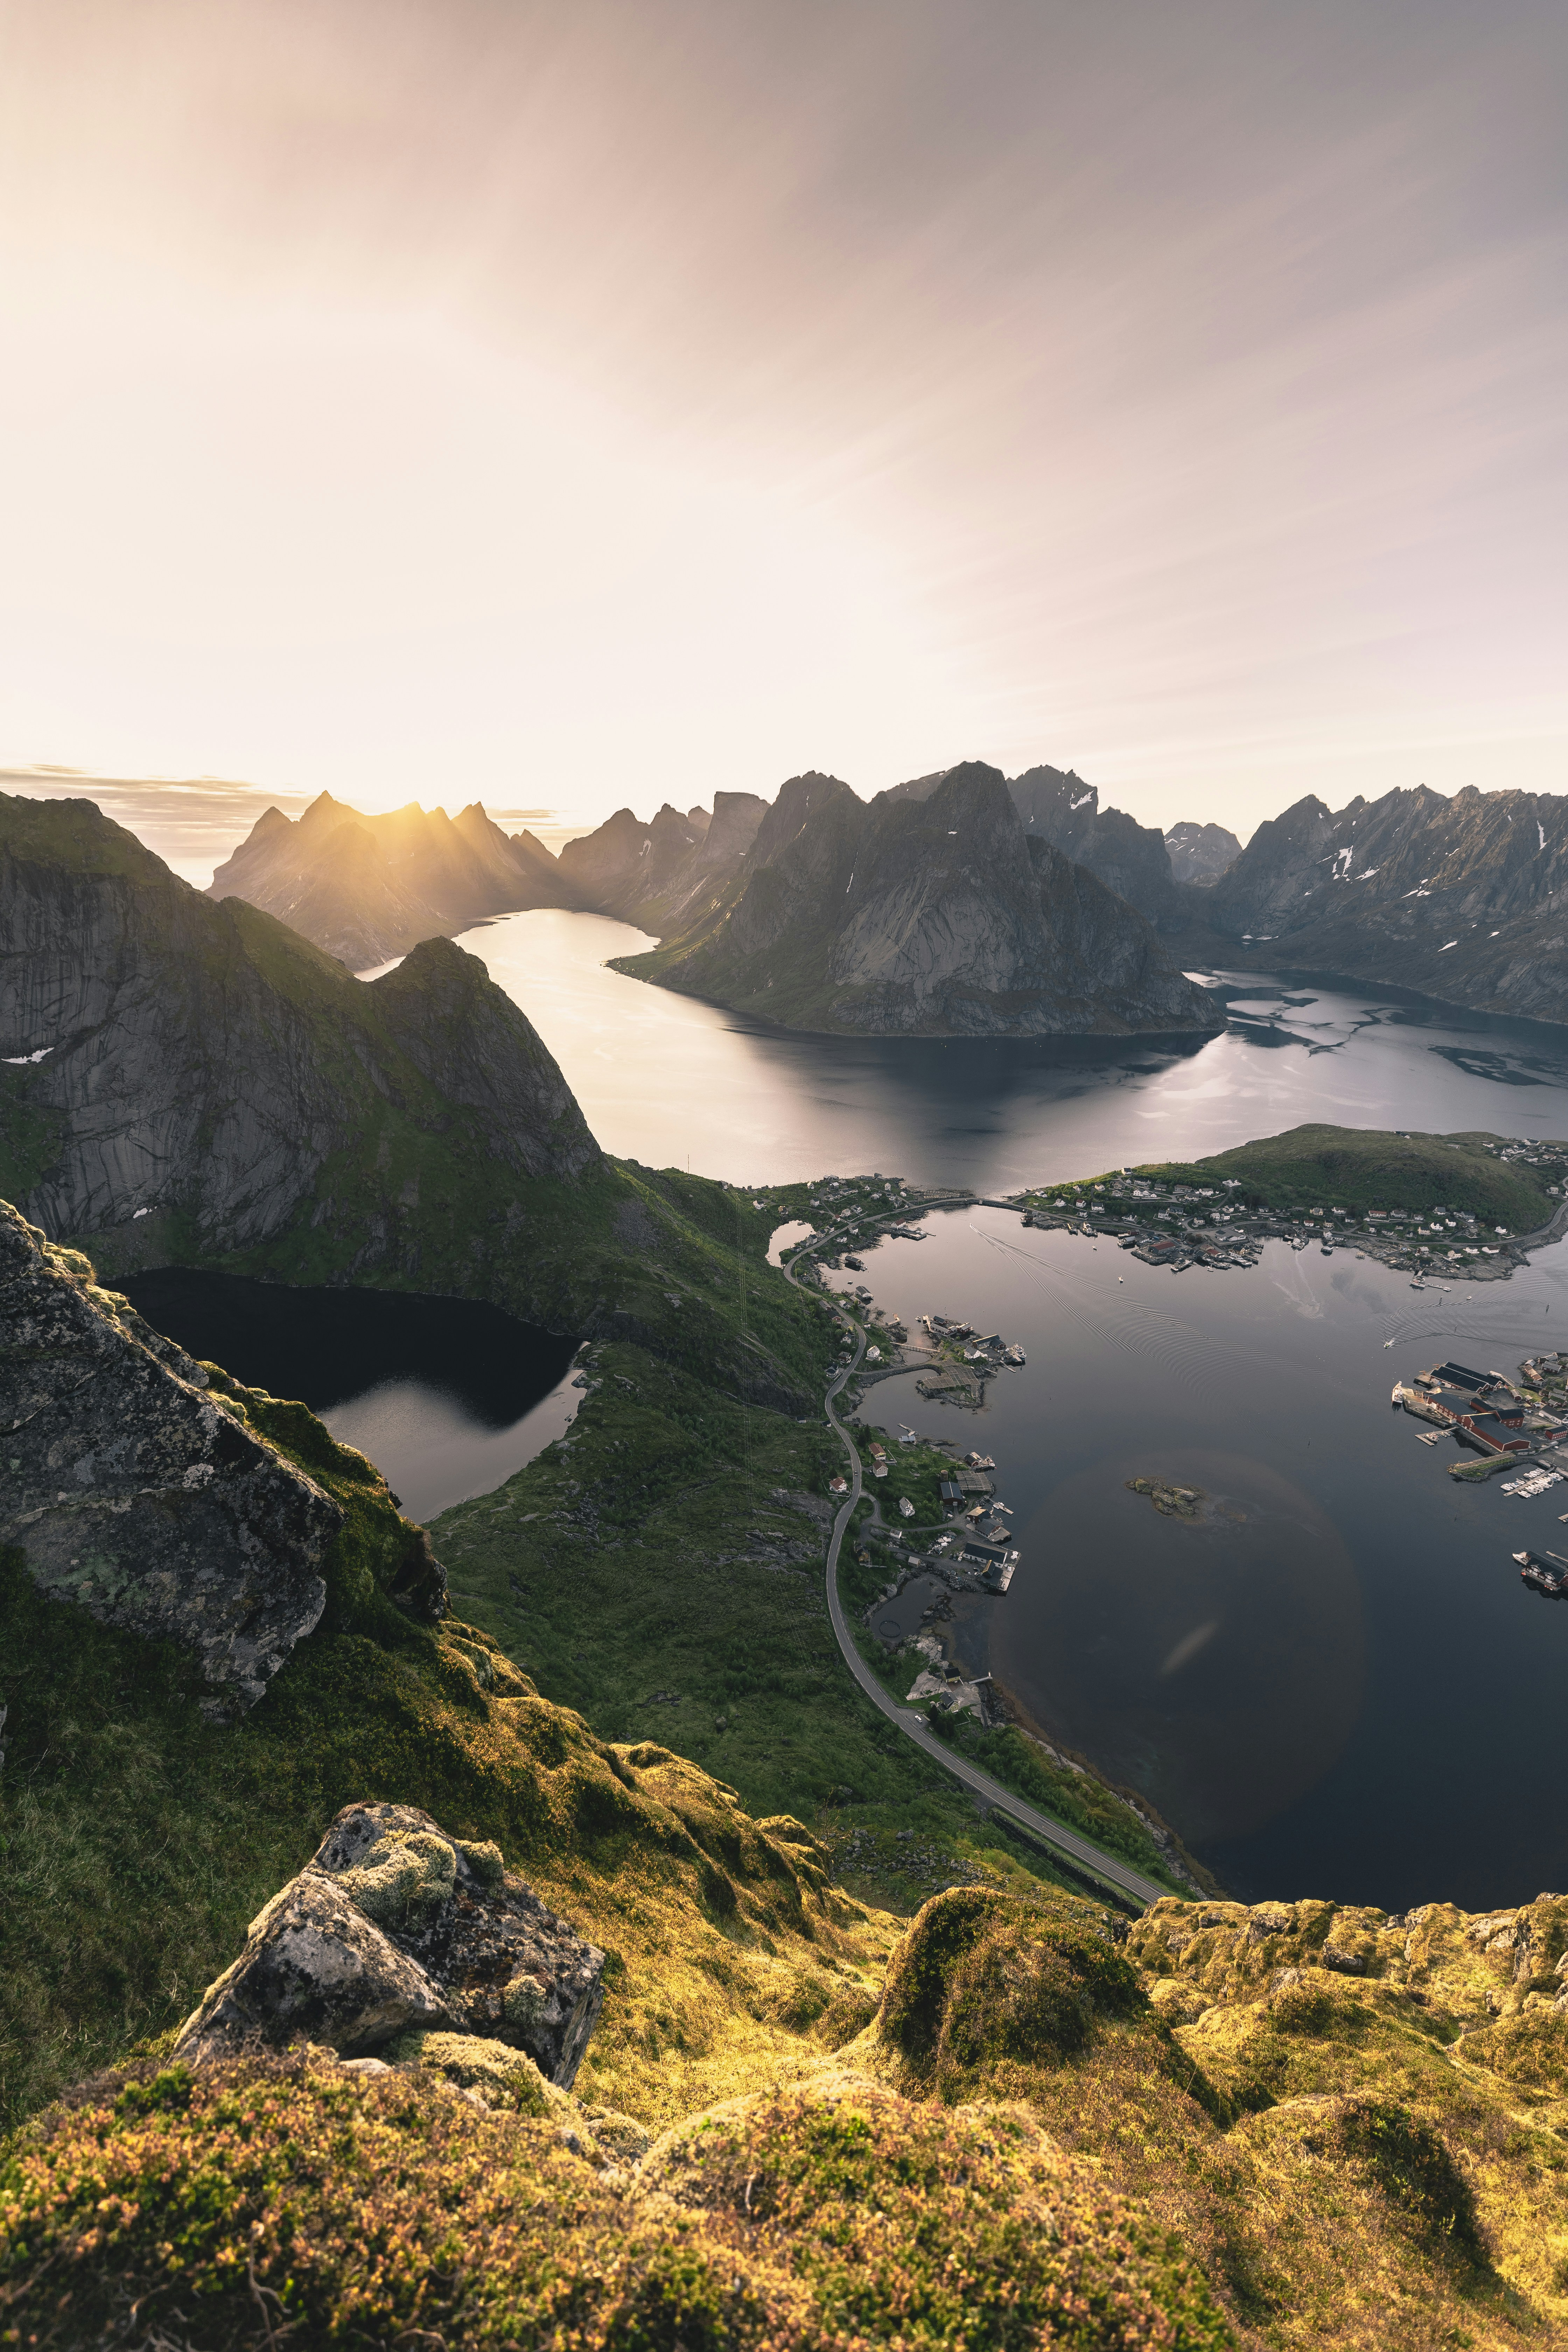

In [2]:
from IPython.display import Image, display
# display with width=300 and center the image
display(Image(filename='../proj3/data/images/cZzC8D5fqIE.jpg', width=300, unconfined=True))

Here is an example run for that query: 

```bash
Loading standard metadata from directory data/metadata...
What image are you looking for? (Type your query, or leave empty to quit if not first query) ▶ Im looking for the picture of a Fjord I took in Norway in 2018. 
 
                                                                                                                                                               Metadata filters from Open AI: {"year": 2018, "photo_location_country": Norway, "photo_location_latitude": 60.472, "photo_description": Fjord in Norway taken inn 2018, "photo_location_longitude": 8.4689}
Current textual query for AI ranking: "Im looking for the picture of a Fjord I took in Norway in 2018."
OpenAI metadata query cost: $0.001683
OpenAI metadata query time: 6711.1 ms

Previewing up to 4 of 4 metadata-filtered results:
- EmSpZYr3hEg: Grassy snowy mountains, Geiranger
- cZzC8D5fqIE: aerial photo of mountains surrounded with body of water during golden hour
- k_NkqIaRhro: man walking beside orange building at daytime
- s73LU7J77Yg: body of water near mountain
Did you find the image you were searching for? (yes, quit / add details / use AI model) ▶ yes
Great! Exiting.
```

Given the user already knew the location, and the date at which he took the picture (Norway/2018) it was relatively easy and short to filter through the images and compare the metadata values to find Norway and 2018 in the corresponding fields. 

### Second scenario: user only knows the description of the picture he's looking for
In this case, the user is interested in finding the image of himself standing in front of a waterfall, but he forgot it was in Iceland. 



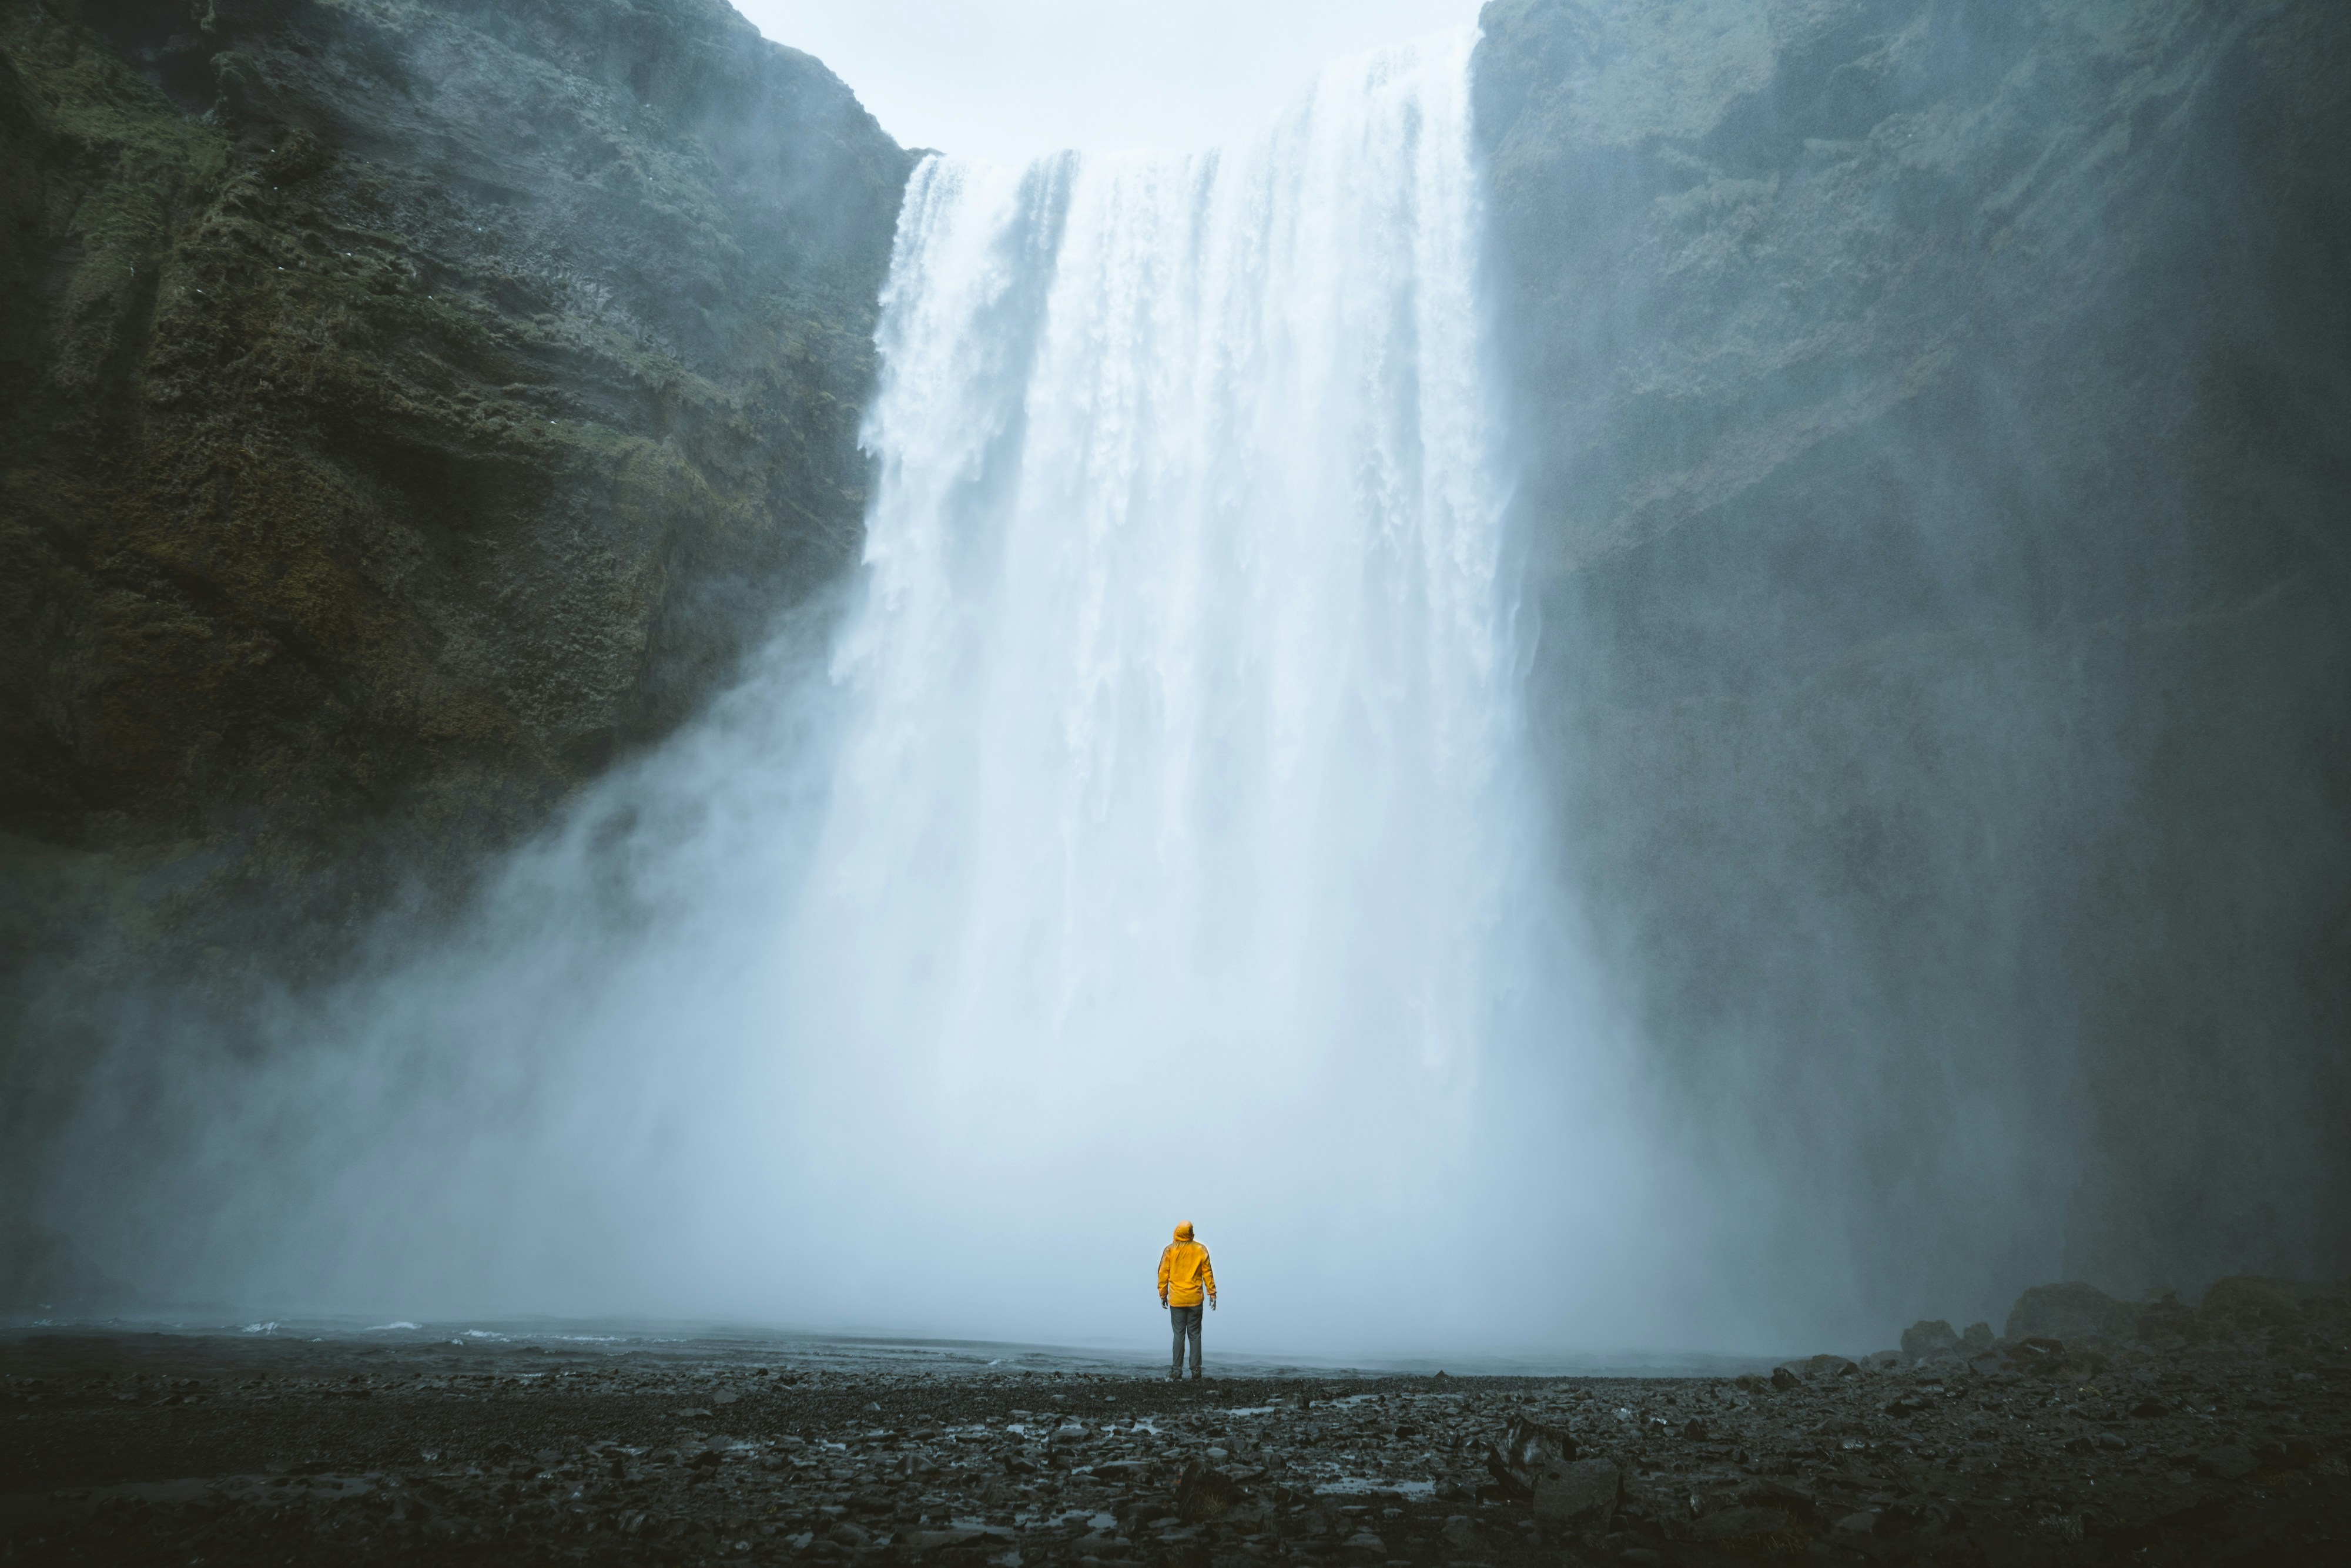

In [7]:
display(Image(filename='../proj3/data/images/YY0vaZV7oIA.jpg', width=400))

See the example run below: 

```bash
PS C:\Users\urkes\uchicago\MPCS52060_ParallelProgramming\project-3-urkeshc\proj3> go run ./cmd/finder
Loading standard metadata from directory data/metadata...
What image are you looking for? (Type your query, or leave empty to quit if not first query) ▶ I took a picture in front of a waterfall but I cant find it anymore, could you find it for me?  

Metadata filters from Open AI: {"photo_description": Picture in front of a waterfall}
Current textual query for AI ranking: "I took a picture in front of a waterfall but I cant find it anymore, could you find it for me?"
OpenAI metadata query cost: $0.001392
OpenAI metadata query time: 8876.2 ms
Local metadata filtering time: 1.5 ms

Filtered candidates by metadata: 1000 / 1000
Metadata filter was not very specific. Applied filtering to metadata, we currently have 1000 potential candidates. Would you like to see the candidates, add more info for metadata (location/date/time/camera used/photographer name) or would you like to use our AI model to analyze and return images that match your description? (Type "see" or "add" or "ai") ▶ ai
Running sequential token-overlap scorer on 1000 metadata-filtered candidates…
AI ranking time: 18.4 ms

Top 5 visual matches from the 1000 candidates:
 1) nf9kjXTk2Ec  —  waterfalls on a cliffside (score 9.10)
 2) WDlqI4aDa4A  —  waterfall top-view photography (score 7.21)
 3) PP5ADw-C8aU  —  man standing front of trees (score 7.15)
 4) fNPzcLbeIqA  —  man standing in front of seashore (score 7.15)
 5) YY0vaZV7oIA  —  Iceland (score 6.42)
Did you find the image you were searching for? (yes, quit / add details / use AI model) ▶ yes
Great! Exiting.
```

The image we were looking for is indeed `YY0vaZV7oIA` i.e. choice 5. 

#### Second scenario: back end perspective

- The Go source files in “internal/meta” and “internal/query” handle metadata loading, filtering, and user query parsing before feeding into the ranking routines. This is the 1st pass.
- “internal/textmatch” provides a simple token overlap scoring mechanism, which is crucial for matching user queries to image descriptions (only used after the user enters "ai"). This is the second pass.
- The parallel approaches in “internal/parallel” (BSP, Pipeline, Work-Stealing) each demonstrate different concurrency models to improve performance on large image datasets. 

At a high level the process is as follows. The user enters a prompt, the prompt is passed through the ./internal/query process and sent to open AI o3-mini. o3 decodes the message and saves it to a Json format. It looks for a description, a location, a date or other relevant data (see the prompt below). Then the json is checked against the metadata values of the images (most of the time, to find a location or date match, in order to filter out images that are clearly irrelevant). After that 1st pass, the user can either choose to see the remaining images after the metadata filtering, or decide to use the 2nd pass and use the AI scorer system. The naive implementation I used, which I shall change to a vision model in future versions of this project, is a sort of similarity between the prompt and the AI Description provided by Unsplash. If user types AI, we return the top 5 best matches by default based on the user's and ai description. 

On a sidenote, another option after the 1st pass is to add infromation, for example if you just remembered the date, you can type "add" and when prompted enter: "I think it was in July of 2020", which will then be passed into Open AI and added to the json object for the user prompt / query.



OpenAi prompt: 

```bash 
Based on the user input, please generate a JSON object with the following photo metadata fields:
{json.dumps(metadata_template, indent=2)}

Infer values where possible. If a field cannot be determined, use null.
You are allowed to infer values based on context, for example, if a country or city is provided, you can impute a random latitude and longitude in that area. 
However, do not invent values if you have no clue; leave them as null unless you are 99% sure of your guess.
For the 'photo_location_country' field, if a country is identified by an alias (e.g., "USA", "UK"), please use its canonical name (e.g., "United States", "United Kingdom").
Return *only* the JSON object (the metadata map itself), not wrapped in any other structure.
```


## Code Structure 
The project structure can be found in ./documentation/project_structure.txt, however, here is a more detailed explanation of each section: 

### Cmd
#### bench
Contains main.go for running benchmarks across different modes and thread counts. Produces CSV timing outputs under results/.

#### finder
The interactive CLI (main.go) that ties together query parsing, metadata filtering, and AI-based ranking. Supports --mode (seq, bsp, pipeline, ws) and --duplicated flags.

#### ranker
Standalone ranking tool (main.go) focused on token-overlap scoring and top-K heap logic, without the full finder workflow.

### Data
#### images
A small sample of Unsplash .jpg images used for demos and the notebook.

#### metadata
metadata/ directory: one JSON side-car file per image for fast local filtering.

#### metadata_big.jsonl: 
large (2.6 GB) JSONL file for large-scale experiments.

### Internal
#### meta

loader.go: loads PhotoMetadata structs from a folder or JSONL.

filter.go: multi-stage metadata filtering (location, date, photographer, camera, description).

#### parallel
##### bsp
Bulk-Synchronous Parallel: splits the photo slice into T chunks, maps each chunk on a goroutine, waits at a barrier, then reduces by merging top-K heaps.

#### pipeline

Pipelined stages:

- Scorers read from candidatesCh, compute scores, send scoredPhoto to resultsCh, which is then collected into a top-K heap. The process is outlined in scorer.go 

##### ws
Work-stealing using a Chase-Lev deque: each worker has a local task deque, pops tasks from one end, and thieves steal from the other to balance uneven workloads (lock-free).

### query
Invokes the Python parser (query_parser.py) to convert free-form text into a Query struct with extracted metadata. Handles initial parse and history merges.

### textmatch

Data: precomputed GloVe neighbors JSON in textmatch/data/glove_neighbors_15k.json.

tokenizer.go: lower-cases, regex-splits, stems (Porter), filters stopwords, expands synonyms.

score.go: builds token sets for query/photo, intersects them to compute weighted scores, and provides a top-K heap in Rank.

### util
Shared helpers:

- Flag registration (mode, workers, scorers, topk, limit, duplicated).

- Timer for millisecond timing.

- Check for error handling.

### Plots
Generated performance charts (PNG) created by scripts/plot_speedup.py from CSVs in results/.

### Results
CSV outputs from cmd/bench showing runtimes for each mode and thread count.

### Scripts
#### dup
Helper scripts to duplicate metadata for synthetic scaling tests.

#### run_all.sh
Shell script to run cmd/bench across all modes and thread counts automatically.

#### plot_speedup.py
Reads CSVs in results/ and generates speedup/runtime plots in plots/.

# Sequential Implementation

## Entry point:

```go
func Rank(query string, photos []meta.PhotoMetadata, k int) []meta.PhotoMetadata { … }
```
- Returns top-K matches or nil if k<=0 or no photos.


## Heap setup:

```go
h := &photoHeap{}  
heap.Init(h)
```
Uses a min-heap of size ≤ K to track the current top scores.

## Main ranking loop (hotspot):

```go
for _, p := range photos {
    s := Score(query, p)  // O(T_score) per photo
    …
}
```
- O(N) calls to Score dominate runtime when N is large.

## Score breakdown:

- Builds a photoText string from descriptions and location.
- Calls getStemmedTokensSet twice (with/without synonyms): regex → lowercase → Porter stem → synonym lookup.
- Loops over stem sets to accumulate rawScore, then normalizes by log(1+|tokens|) to control for large messages (else very large messages get high score even if they have nothing to do with the user's description)

## Heap maintenance:

- Push until h.Len()<k, then compare new score vs h[0] and Pop/Push if higher.
- Ensures O(log k) per replacement.

## Final extraction & sort:

```go
scored := make([]scoredPhoto, h.Len())
for i := range scored {
    scored[i] = heap.Pop(h).(scoredPhoto)
}
sort.Slice(scored, …)  // descending score, downloads, ascending ID
```

## Performance characteristics:

- Runtime ≈ O(N × T_score + N × log k).
- For K≪N, log k is negligible; scoring cost (string ops, stemming, map lookups) dominates.

## Metadata filtering 
- (in meta.FilterPhotos) runs in <1 ms for thousands of entries, so the true bottleneck is the token-overlap scorer.

## Key takeaway:
- The single-threaded Rank loops over every candidate, invoking a relatively heavy text-processing Score per image, making it an ideal hotspot for parallel speedup.

# Parallel Versions

## BSP (Bulk-Synchronous Parallel)
**Key Components:**

- `Barrier` synchronization primitive (`barrier.go`)
- Chunk-based work distribution with local heaps
- Two-phase reduce operation

**Implementation:**

1. **Barrier**: 

   - Uses `sync.Mutex` + `sync.Cond` for thread coordination
   - Resets automatically after each synchronization point

2. **Scoring Phase**:

   - Divides photos into equal chunks (1 per worker)
   - Each worker maintains its own min-heap of top-K results
   - Workers synchronize via barrier after local scoring

3. **Reduce Phase**:
   - Main thread merges all local heaps
   - Final sort by score (desc), downloads (desc), photo ID (asc)

**Optimizations:**

- Dynamic worker count adjustment (never more workers than photos)
- Heap operations optimized for tie-breaking cases
- Zero-allocation design for scoring hot path

**Tradeoffs:**

- (+) Simple synchronization model
- (-) Requires all workers to finish before reduce phase
- (-) Static work distribution can lead to imbalance

## Pipeline
**Key Components:**

- Buffered channels for inter-stage communication
- Fan-out/fan-in worker pattern
- Concurrent scoring with centralized collection

**Implementation:**

1. **Producer**:

   - Feeds filtered photos into scoring channel
   - Closes channel when done (sentinel value)

2. **Scorers**:

   - Worker pool reads from shared input channel
   - Scores photos using TF-IDF + synonyms
   - Writes results to output channel

3. **Collector**:

   - Maintains global top-K heap
   - Sorts final results identically to BSP version

**Optimizations:**

- Channel buffers sized to prevent stalling
- Early termination if topK = 0
- Shared heap implementation across versions

**Tradeoffs:**

- (+) Natural load balancing via shared queue
- (-) Central collector can become bottleneck
- (+) Easier to extend with additional stages

## Work-Stealing (WS)
**Key Components:**

- Per-worker deques (`deque.go`)
- Randomized steal attempts
- Thread-safe collector

**Implementation:**

1. **Task Distribution**:

   - Initial round-robin assignment to deques
   - Each photo becomes a `Task` struct

2. **Workers**:

   - Prioritize local tasks (LIFO)
   - Steal from random peers (FIFO) when idle
   - Exponential backoff on failed steals

3. **Termination**:

   - WaitGroup tracks remaining tasks
   - Quit channel signals workers to exit

**Optimizations:**

- Lock-free design for local operations
- Randomized steal targets reduce contention
- Per-worker RNG for steal patterns

**Tradeoffs:**

- (+) Excellent load balancing
- (+) Scales with irregular workloads
- (-) More complex synchronization
- (-) Stealing overhead for small tasks

**Common Infrastructure:**

All versions share:

- Identical `scoredPhoto` and `photoHeap` types
- Same tie-breaking logic (score → downloads → photo ID)
- Unified text scoring via `textmatch.Score()`


# Experimental Methodology

## Why synthetic datasets?

- **Objective:** Our core goal is to **demonstrate the impact of parallelism** on a compute-heavy ranking stage. In real life, a computer-vision inference per image (e.g. running a CNN) can take tens to hundreds of milliseconds each—so even thousands of photos quickly become a long serial bottleneck.  
- **Limitation of real metadata:** The Unsplash metadata (≈1 000 entries) alone ranks in just a few milliseconds, so we wouldn’t observe any speedups. We can’t bundle millions of unique images here (storage and privacy), nor run a full CV model in Go.  
- **Solution:** **Duplicate** our 1 000-entry metadata block up to 25 million entries. This artificially **stretches the ranking workload** so that:

  1. We still use the same codepath (text-overlap scorer acting as a stand-in for “heavy” CV work).  
  2. The serial runtime rises into seconds, making parallel speedups observable.  
  3. We can compare `seq`, `bsp`, `pipeline`, and `ws` modes under controlled, reproducible conditions.

## Dataset sizes  

- **100 K entries** (×100)  
- **1 M entries** (×1 000)  
- **25 M entries** (×2 500)  

Each size represents a progressively harder ranking problem. Those are just examples, but you can change the set size depending on your choice when calling the program with the flag `--duplicated N` for a set of size N. 

## What we measure  

- **Ranking time** (`time_ms`): only the in-memory top-K scoring phase (i.e. our stand-in for CV inference).  
- We _exclude_ OpenAI parsing and metadata filtering from the timer.

## Experiment matrix  

| Mode       | Threads       | Dataset sizes      |
|------------|---------------|--------------------|
| seq        | 1             | 100 K, 1 M, 25 M  |
| bsp        | 1,2,4,8,16    | 100 K, 1 M, 25 M  |
| pipeline   | 1,2,4,8,16    | 100 K, 1 M, 25 M  |
| ws         | 1,2,4,8,16    | 100 K, 1 M, 25 M  |

## Automation & reproducibility  

1. **Benchmark driver**:  
   - `cmd/bench/main.go` loads `--dataset data/metadata_big.jsonl`, slices to `--size N`, runs `meta.FilterPhotos` (not timed), then times only the chosen ranking function (`Rank`, `RankBSP`, `RankScoringPipeline`, `RankWS`).  
   - Emits CSV rows:  
     ```
     mode,threads,size,time_ms
     bsp,4,1000000,8136.314
     ```

2. **Orchestration script**:  
   - `scripts/run_all.sh` loops over modes, thread counts, and sizes, appending to `results/results.csv`.  

3. **Plotting**:  
   - `scripts/plot_speedup.py` reads the CSV, computes  
     ```
     speedup = T₁ (seq baseline) / Tₙ
     ```  
   - Produces **speedup vs. threads** curves for each mode & dataset.  

---

> **Takeaway:** by stretching our ranking stage to millions of items, we mimic the compute intensity of a full CV inference pipeline—allowing us to **quantify and compare** how each parallel strategy scales.



# Results

## Tables

f

## Speedup graphs

f
## Observations
f

# Discussion

Load balancing: which strategy keeps threads busy under skew?

Overheads: task creation, synchronization, channel ops, deque locks

Hotspots: ranking kernel remains dominant

Bottlenecks: metadata filtering is negligible; ranking dominates

Effectiveness: How far did each mode scale? Diminishing returns?



# Conclusion and Future Work






When work-stealing shines (heterogeneous task costs)

Possibility of GPU / SIMD for token scoring

Caching token sets, precomputing embeddings, etc.

Recap: we built a GPT-driven image finder, scaled ranking to millions with three parallel patterns, and achieved X× speedup.